CNN Model to detect horse and human

* tf.data.dataset array instead of ndarray
* Rescaling
* cache,shuffle,prefetch
* plot history
* upload file

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from zipfile import ZipFile
with ZipFile('archive.zip') as zip:
    zip.extractall()

In [ ]:
# tf.data.Dataset

In [ ]:
TRAIN_DATA = 'horse-or-human/train'

Load Dataset using tensorflow

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA, # it must contain two(or more) sub directory that contains images for each class
    image_size=(300,300), # size of image
    batch_size= 128,
    label_mode='binary'
)

Found 1027 files belonging to 2 classes.


In [ ]:
VALIDATAION_DATA = 'horse-or-human/validation'

In [ ]:
recycle_layer = tf.keras.layers.Rescaling(scale= 1. / 255)
train_data_scaled = train_data.map(lambda image,label:( recycle_layer(image),label))

In [ ]:
train_data_final = (train_data_scaled
                    .cache()
                    .shuffle(buffer_size=1000)
                    .prefetch(buffer_size=tf.data.AUTOTUNE))

In [ ]:
validation_data = tf.keras.utils.image_dataset_from_directory(
    VALIDATAION_DATA,
    image_size=(300,300),
    batch_size=128,
    label_mode='binary'
)

Found 256 files belonging to 2 classes.


In [ ]:
recycle_layer = tf.keras.layers.Rescaling(scale=1./255)
validation_data_rescale = validation_data.map(lambda image,label: (recycle_layer(image),label))

In [ ]:
validation_data_final = validation_data_rescale.cache().shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(300,300,3)),
    # convolution layer(create a 3X3 matrix and multiply it with corresponding value in the image matrix)
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    # max filtering (filter the maximum value from each 2X2 matrix and replace that matrix by that single value)
    tf.keras.layers.MaxPooling2D(2, 2),
    # repeat
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    # flatten the input into one dimensional
    tf.keras.layers.Flatten(),
    # create a hidden dense layer
    tf.keras.layers.Dense(units=512, activation='relu'),
    # output layer
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
# compile model using adam optimizer and spatialcategoricalentropy as loss function and accuray as metrics
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 149, 149, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 35, 35, 64)      

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['loss'] < 0.2 and logs['accuracy'] > 0.95:
            self.model.stop_training = True

In [ ]:
history = model.fit(train_data_final,epochs=15,validation_data=validation_data_final,verbose=2,callbacks=[CustomCallback()])

Epoch 1/15
9/9 - 70s - loss: 4.3136 - accuracy: 0.4927 - val_loss: 0.6890 - val_accuracy: 0.5000 - 70s/epoch - 8s/step
Epoch 2/15
9/9 - 54s - loss: 0.6347 - accuracy: 0.6767 - val_loss: 0.8563 - val_accuracy: 0.5000 - 54s/epoch - 6s/step
Epoch 3/15
9/9 - 52s - loss: 0.5953 - accuracy: 0.7215 - val_loss: 0.9243 - val_accuracy: 0.5000 - 52s/epoch - 6s/step
Epoch 4/15
9/9 - 55s - loss: 0.5300 - accuracy: 0.7244 - val_loss: 0.5833 - val_accuracy: 0.6367 - 55s/epoch - 6s/step
Epoch 5/15
9/9 - 61s - loss: 0.3230 - accuracy: 0.8861 - val_loss: 0.4748 - val_accuracy: 0.6719 - 61s/epoch - 7s/step
Epoch 6/15
9/9 - 62s - loss: 0.4125 - accuracy: 0.8169 - val_loss: 0.3492 - val_accuracy: 0.8438 - 62s/epoch - 7s/step
Epoch 7/15
9/9 - 67s - loss: 0.2323 - accuracy: 0.9202 - val_loss: 1.3667 - val_accuracy: 0.6680 - 67s/epoch - 7s/step
Epoch 8/15
9/9 - 62s - loss: 0.2633 - accuracy: 0.8832 - val_loss: 0.8183 - val_accuracy: 0.7734 - 62s/epoch - 7s/step
Epoch 9/15
9/9 - 67s - loss: 0.1363 - accuracy: 

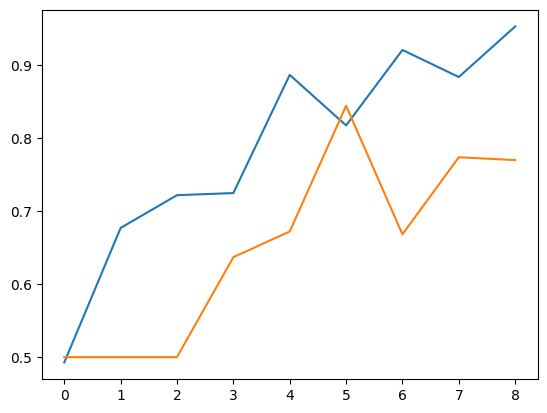

In [ ]:
acc = history.history['accuracy']
val_loss = history.history['val_accuracy']
plt.plot(range(len(acc)),acc)
plt.plot(range(len(val_loss)),val_loss)

In [ ]:
'''
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    path = '/content/' + fn
    img = tf.keras.preprocessing.image.load_img(path, target_size=(300,300))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x,axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0] > 0.5:
        print(fn + " is a human")
    else:
            print(fn+' is a horse')
'''

'\nfrom google.colab import files\n\nuploaded = files.upload()\n\nfor fn in uploaded.keys():\n    path = \'/content/\' + fn\n    img = tf.keras.preprocessing.image.load_img(path, target_size=(300,300))\n    x = tf.keras.preprocessing.image.img_to_array(img)\n    x = np.expand_dims(x,axis=0)\n    images = np.vstack([x])\n    classes = model.predict(images, batch_size=10)\n    print(classes[0])\n    if classes[0] > 0.5:\n        print(fn + " is a human")\n    else:\n            print(fn+\' is a horse\')\n'